In [38]:
import locale
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so
import urllib.request
import zipfile


In [74]:
import xgboost as xgb
from feature_engine import encoding, imputation
from sklearn import base, pipeline
from sklearn import model_selection
from sklearn import tree
from sklearn import dummy
from sklearn import preprocessing

In [3]:
locale.setlocale(locale.LC_ALL, "es_ES.UTF-8")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.1f}".format)

### Set Variables and Paths

*Variables*

In [4]:
url: str = (
    "https://github.com/mattharrison/datasets/raw/master/data/" "kaggle-survey-2018.zip"
)
folder_name: str = "kaggle-survey-2018.zip"
member_name: str = "multipleChoiceResponses.csv"

*Paths*

In [5]:
HOME: Path = Path.cwd().parents
data_folder: Path = HOME[1] / f"data/raw/{folder_name}"

### Helper Funcs

In [6]:
def extract_zip(src: str, dst: str, member_name: str) -> pd.DataFrame:
    """Extract a member file from a zipfile and read it into a pandas
    DataFrame

    Args:
        src: str 
            Url of the zip file to be download and extracted.
        dst: Path, str, 
            Local file path where the zip file will be written.
        member_name: str
            Name of the member file inside the zip file
            to be read into a DataFrame.

    Returns:
        pandas.DataFrame: DataFrame containing the contents of the
        member file
    """
    url = src
    data_folder = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode="wb") as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name), low_memory=False)
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

In [7]:
def top_n(ser: pd.Series, n:int=5, default:str='other') -> pd.Series:
    """
    Replace all values in a Pandas Series that are not among
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new
    Series with the values replaced as described above. The
    top `n` most frequent values are determined using the
    `value counts`method of the input Series.

    Args:
        ser: Pd.Series,
            The input Series.
        n: int, optional, default `5`
            The number of most frequent values to keep.
        default: str, default `other`, optional
            The default values to use for values that are not among
            the top `n`mos frequent values.

    Returns:
        pd.Series
            The modified Series with the values replaced.
    """
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [8]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the kaggle survey data and return a new DataFrame.

    This function takes a Pandas Dataframe containing Kaggle
    survey data as input and returns a new DataFrame. The modifications include extracting
    and trasforming certian columns, renaming columns, and selecting subset of columns.

    Args:
        df_: pd.DataFrame 
            The input DataFrame containing kaggle survey data.

    Returns:
        pd.DataFrame 
            the new DataFrame with the modified and selected columns.
    """
    return (
        df_
        .assign(age=df_.Q2.str.slice(0, 2).astype(int),
                education=df_.Q4.replace({
                    "Master’s degree": 18,
                    "Bachelor’s degree": 16,
                    "Doctoral degree": 20,
                    "Some college/university study without earning a bachelor’s degree": 13,
                    "Professional degree": 19,
                    "I prefer not to answer": None,
                    "No formal education past high school": 12}),
                major=(
            df_.Q5
            .pipe(top_n, n=3)
            .replace({
                "Computer science (software engineering, etc.)": 'cs',
                "Engineering (non-computer focused)": 'eng',
                "Mathematics or statistics": "stat"
            })),
            years_exp=(
                df_.Q8.str.replace('+', '', regex=False)
                .str.split("-", expand=True)
                .iloc[:, 0]
                .astype(float)),
            compensation=(
                df_.Q9.str.replace('+', '', regex=False)
                .str.replace(',', '', regex=False)
                .str.replace('500000', '500', regex=False)
                .str.replace("I do not wish to disclose my approximate yearly compensation",
                             '0', regex=False)
                .str.split('-', expand=True)
                .iloc[:, 0]
                .fillna(0)
                .astype(int)
                .mul(1_000)),
            python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
            r=df_.Q16_Part_2.fillna(0).replace('R', 1),
            sql=df_.Q16_Part_3.fillna(0).replace("SQL", 1)
        )  # Assign
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,python,r,sql'.split(',')]
    )


In [9]:
def get_rawX_y(df: pd.DataFrame, y_col):
    raw = (
        df
        .query("Q3.isin(['United States of America', 'China', 'India']) and Q6.isin(['Data Scientist', \
               'Software Engineer'])")
    )
    return raw.drop(columns=[y_col]), raw[y_col]


### Classes

In [10]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):
    """
    A trasformer for tweaking Kaggle survey data.

    This trasformer takes a Pandas DataFrame containing
    Kaggle survey data as input and returns a new version of
    the DataFrame. The modifications include extracting and
    trasforming certain columns, renaming columns, and
    selecting a subset of columns.

    Args:
        ycol: str, optional
            The name of the column to be used as the target variables.
            If not specified, the target variable will not be set.
            
    Attributes:
        ycol: str
            The name of the column to be used as the target variable.
    """

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self

#### Datasets

In [11]:
raw = extract_zip(url, data_folder, member_name)

#### Create a pipeline

In [13]:
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
    variables=['education', 'years_exp']))]
)

In [14]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [15]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (
    model_selection.train_test_split(
        kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y
    )
)


In [16]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

In [17]:
x_test = kag_pl.transform(kag_X_test)

In [18]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

## EDA

In [19]:
(
    X_train
    .assign(data_scientist = kag_y_train == 'Data Scientist')
    .corr(method='spearman')
    .style
    .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
    .set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


*BarPlot*

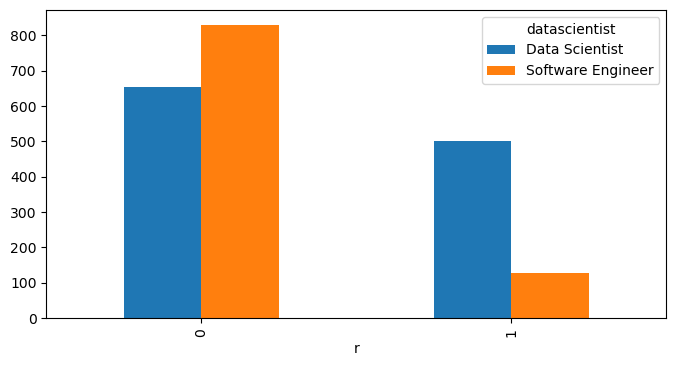

In [30]:
# r = 0.32 positive correlation
fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .assign( datascientist=kag_y_train)
    .groupby('r')
    .datascientist
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
plt.show()

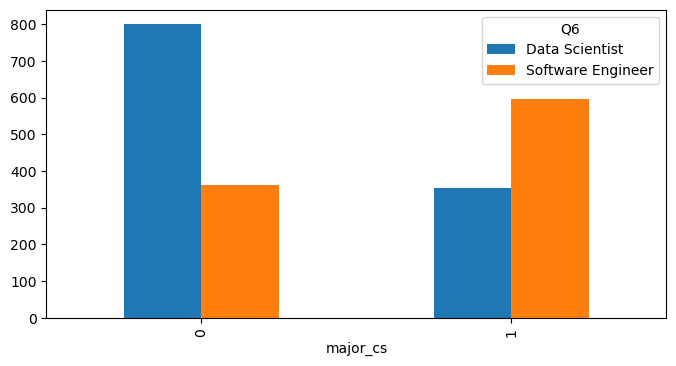

In [35]:
# Major most negative correlation -0.31
fig, ax = plt.subplots(figsize=(8, 4))
(
    pd.crosstab(index=X_train['major_cs'], columns=kag_y)
    .plot.bar(ax=ax)
)
plt.show()

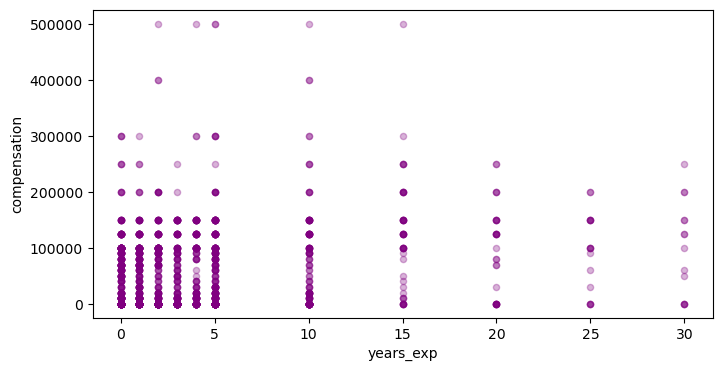

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)
plt.show()

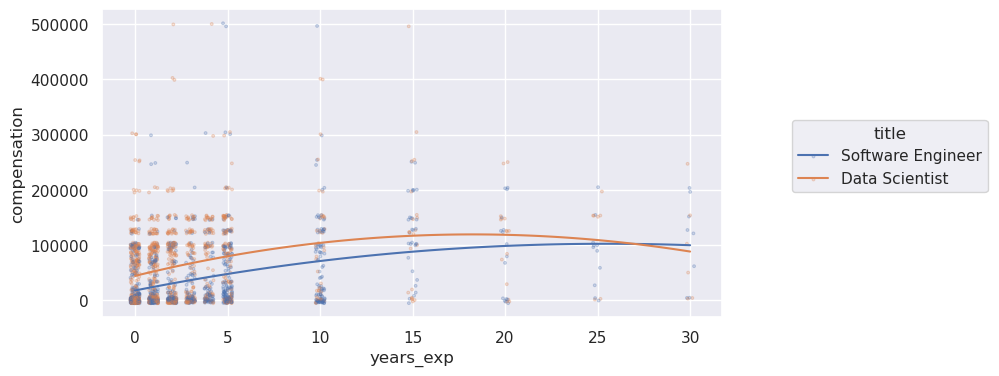

In [40]:
# Fix that binned data
fig = plt.figure(figsize=(8, 4))
(
    so
    .Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
    .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
    .add(so.Line(), so.PolyFit())
    .on(fig) # not required unless saving to image
    .plot()
)
plt.show()

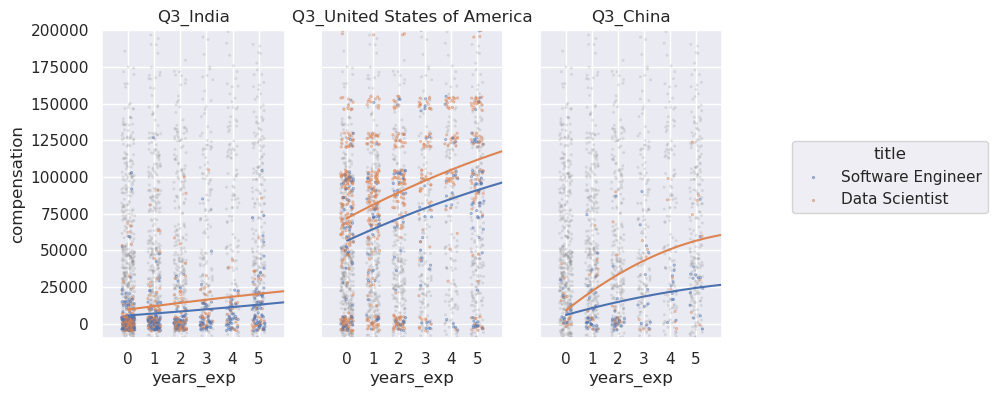

In [46]:
fig = plt.figure(figsize=(8, 4))
(
    so
    .Plot(
        X_train
#        .query('compensation < 200_000 and years_exp < 16')
        .assign(
            title=kag_y_train,
            country=(X_train
                     .loc[:, 'Q3_United States of America': 'Q3_China']
                     .idxmax(axis='columns')
                     )
        ), x='years_exp', y='compensation', color='title'
        ) 
    .facet('country')
    .add(so.Dots(alpha=.01, pointsize=2, color='grey'), so.Jitter(x=.5, y=10_0000), col=None)
    .add(so.Dots(alpha=.5, pointsize=1.5), so.Jitter(x=.5, y=10_000))
    .add(so.Line(pointsize=1), so.PolyFit(order=2))
    .scale(x=so.Continuous().tick(at=[0, 1, 2, 3, 4, 5]))
    .limit(y=(-10_000, 200_000), x=(-1, 6)) # Zoom in with this not .query(above)
    .on(fig)
    .plot()

)
plt.show()


# ScikitLearn and stump

In [49]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)

In [50]:
X_train = kag_pl.fit_transform(kag_X_train)

In [51]:
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

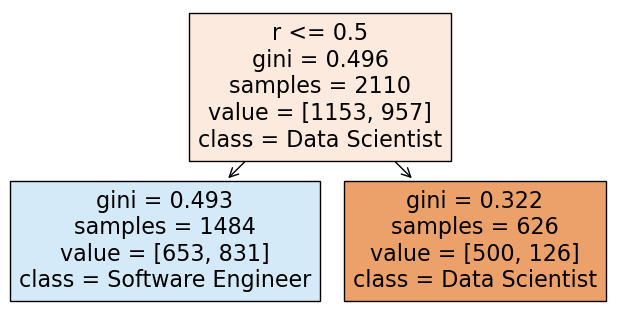

In [54]:
# lets graph it
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(stump_dt, feature_names=features,
               filled=True,
               class_names=stump_dt.classes_,
               ax=ax)
plt.show()

In [55]:
X_test = kag_pl.transform(kag_X_test)

In [57]:
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

In [59]:
# DummyClassifier
dummy_model = dummy.DummyClassifier()

In [60]:
dummy_model.fit(X_train, kag_y_train)

DummyClassifier()

In [61]:
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

# XGBOOST MODEL

In [73]:
kag_y_train == 'Software Engineer'

587       True
3065     False
8435     False
3110     False
16372     True
         ...  
16608     True
7325      True
21810    False
4917     False
639      False
Name: Q6, Length: 2110, dtype: bool

In [75]:
label_encoder = preprocessing.LabelEncoder()

In [76]:
y_train = label_encoder.fit_transform(kag_y_train)

In [77]:
y_test = label_encoder.transform(kag_y_test)

In [78]:
y_test[:5]

array([1, 0, 0, 1, 1])

In [79]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [80]:
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [81]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)


In [82]:
kag_stump.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [83]:
kag_stump.score(X_test, y_test)

0.6243093922651933